In [1]:
import os 
import itertools
import shutil
import random
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [2]:
#split the data into train,valid,test data
os.chdir('data/picture')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for i in random.sample(glob.glob('cat*'),1000):
        shutil.move(i, 'train/cat')
    for i in random.sample(glob.glob('dog*'),1000):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'),200):
        shutil.move(i, 'valid/cat')
    for i in random.sample(glob.glob('dog*'),200):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'),1000):
        shutil.move(i, 'test/cat')
    for i in random.sample(glob.glob('dog*'),1000):
        shutil.move(i, 'test/dog')

os.chdir('../../')

In [2]:
train_path ='data/picture/train'
valid_path ='data/picture/valid'
test_path = 'data/picture/test'

In [3]:
#shear_range,zoom_range,horizontal_flip to prevent overfitting problems
# target_size =(224,224) is in order to perform Fine_tuned VGG16 model in the last of the notebook
train_datagen=ImageDataGenerator(shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
valid_datagen=ImageDataGenerator(shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [4]:
train_generator=train_datagen.flow_from_directory(directory=train_path,target_size=(224,224),classes=['cat','dog'],batch_size=20)
valid_generator=train_datagen.flow_from_directory(directory=valid_path,target_size=(224,224),classes=['cat','dog'],batch_size=20)
test_generator=train_datagen.flow_from_directory(directory=test_path,target_size=(224,224),classes=['cat','dog'],batch_size=20,shuffle=False)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
imgs, labels=next(train_generator)

def plotImages(images):
    fig,axes =plt.subplots(1,10,figsize=(20,20))
    axes=axes.flatten()
    for img,ax in zip(images,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

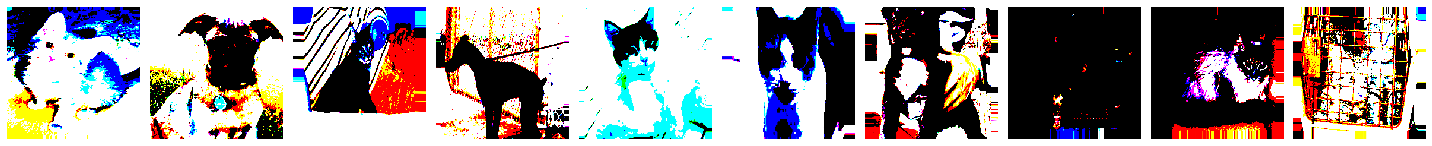

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [6]:
plotImages(imgs)
print(labels)

# Build and train the model

In [7]:
cnn = tf.keras.models.Sequential()

In [8]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',input_shape=[224, 224, 3]))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.2))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units=2, activation='softmax'))

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

In [10]:
cnn.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.001), metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [13]:
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop, reduce_lr]

In [14]:
cnn.fit(x=train_generator,
          validation_data=valid_generator,
          epochs =30,
          validation_steps=20,
          callbacks=callbacks,
          steps_per_epoch=100,
          verbose=2)


Train for 100 steps, validate for 20 steps
Epoch 1/30
100/100 - 90s - loss: 1.0494 - accuracy: 0.5675 - val_loss: 0.8712 - val_accuracy: 0.6425
Epoch 2/30
100/100 - 88s - loss: 0.6649 - accuracy: 0.6480 - val_loss: 0.6909 - val_accuracy: 0.6500
Epoch 3/30
100/100 - 87s - loss: 0.6087 - accuracy: 0.6680 - val_loss: 0.6295 - val_accuracy: 0.6925
Epoch 4/30
100/100 - 86s - loss: 0.5765 - accuracy: 0.7060 - val_loss: 0.6484 - val_accuracy: 0.6450
Epoch 5/30
100/100 - 86s - loss: 0.5391 - accuracy: 0.7320 - val_loss: 0.6558 - val_accuracy: 0.6550
Epoch 6/30
100/100 - 88s - loss: 0.5405 - accuracy: 0.7195 - val_loss: 0.7354 - val_accuracy: 0.6775
Epoch 7/30
100/100 - 88s - loss: 0.5180 - accuracy: 0.7385 - val_loss: 0.6326 - val_accuracy: 0.6825
Epoch 8/30
100/100 - 87s - loss: 0.5015 - accuracy: 0.7600 - val_loss: 0.7094 - val_accuracy: 0.6575
Epoch 9/30
100/100 - 91s - loss: 0.4259 - accuracy: 0.8030 - val_loss: 0.5540 - val_accuracy: 0.7075
Epoch 10/30
100/100 - 89s - loss: 0.4017 - accur

In [32]:
predictions=cnn.predict(x=test_generator,verbose=0)

In [36]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [40]:
print(np.argmax(predictions,axis=-1))

[0 1 0 ... 1 1 1]


In [45]:
cm=confusion_matrix(y_true=test_generator.classes,y_pred=np.argmax(predictions,axis=-1))

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[817 183]
 [348 652]]


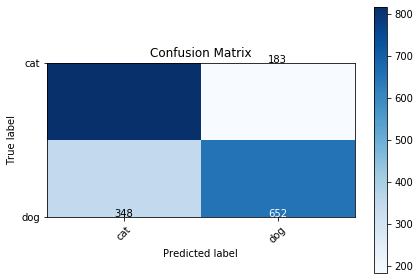

In [47]:
cm_plot_labels=['cat','dog']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [48]:
if os.path.isfile('models/cnn_model.h5') is False:
    cnn.save('models/cnn_model.h5')
    

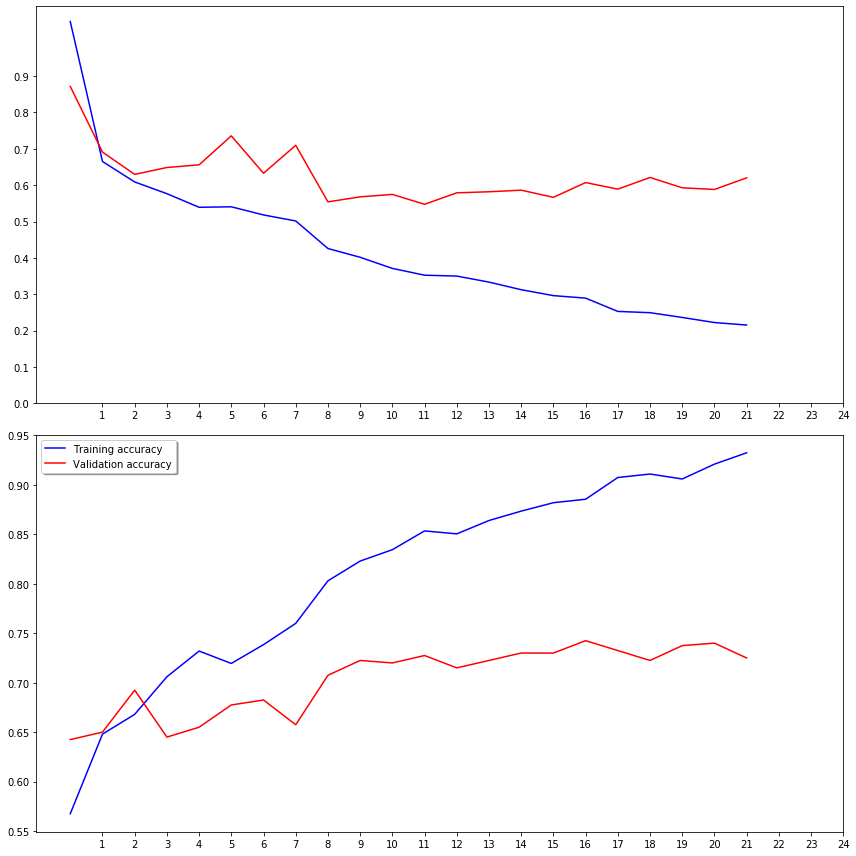

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(cnn.history.history['loss'], color='b', label="Training loss")
ax1.plot(cnn.history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(cnn.history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(cnn.history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [50]:
print(classification_report(y_true=test_generator.classes,y_pred=np.argmax(predictions,axis=-1)))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75      1000
           1       0.78      0.65      0.71      1000

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.74      0.73      0.73      2000



In [59]:
from sklearn.metrics import roc_curve,roc_auc_score

In [56]:
cnn_fpr, cnn_tpr, threshold = roc_curve(test_generator.classes, np.argmax(predictions,axis=-1))

In [60]:
roc_auc_score(test_generator.classes, np.argmax(predictions,axis=-1))

0.7345

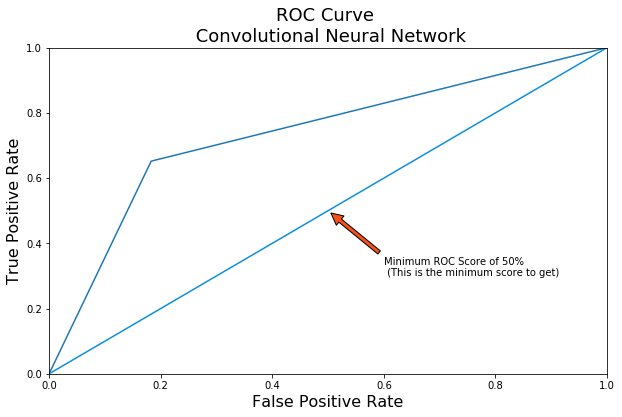

In [85]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('ROC Curve \n Convolutional Neural Network', fontsize=18)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
            
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )
    
    
graph_roc_curve(cnn_fpr, cnn_tpr, threshold)
plt.show()

In [ ]:
if os.path.isfile('models/cnn_model.h5') is False:
    cnn.save('models/cnn_model.h5')

# Fine-Tuned Neural Network with VGG 16 Model

In [67]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [68]:
cnn_16= tf.keras.models.Sequential()
for layer in vgg16_model.layers[:-1]:
    cnn_16.add(layer)
    

In [69]:
for layer in cnn_16.layers:
    layer.trainable = False

In [70]:
cnn_16.add(tf.keras.layers.Dense(units=2, activation='softmax'))
cnn_16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [71]:
cnn_16.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
earlystop_cnn_16 = EarlyStopping(patience=3)
reduce_lr_16 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)
callbacks=[earlystop_cnn_16,reduce_lr_16]

In [73]:
cnn_16.fit(x=train_generator,
          validation_data=valid_generator,
          epochs =30,
          validation_steps=20,
          callbacks=callbacks,
          steps_per_epoch=100,
          verbose=2)


Train for 100 steps, validate for 20 steps
Epoch 1/30
100/100 - 767s - loss: 0.1302 - accuracy: 0.9535 - val_loss: 0.0935 - val_accuracy: 0.9675
Epoch 2/30
100/100 - 788s - loss: 0.0512 - accuracy: 0.9810 - val_loss: 0.1006 - val_accuracy: 0.9725
Epoch 3/30
100/100 - 775s - loss: 0.0455 - accuracy: 0.9840 - val_loss: 0.0574 - val_accuracy: 0.9775
Epoch 4/30
100/100 - 774s - loss: 0.0330 - accuracy: 0.9910 - val_loss: 0.1329 - val_accuracy: 0.9625
Epoch 5/30
100/100 - 772s - loss: 0.0170 - accuracy: 0.9955 - val_loss: 0.1365 - val_accuracy: 0.9650
Epoch 6/30
100/100 - 773s - loss: 0.0183 - accuracy: 0.9915 - val_loss: 0.0935 - val_accuracy: 0.9725


In [74]:
predictions_16=cnn_16.predict(x=test_generator,verbose=0)
np.round(predictions_16)
cm_16=confusion_matrix(y_true=test_generator.classes,y_pred=np.argmax(predictions_16,axis=-1))

Confusion matrix, without normalization
[[980  20]
 [ 31 969]]


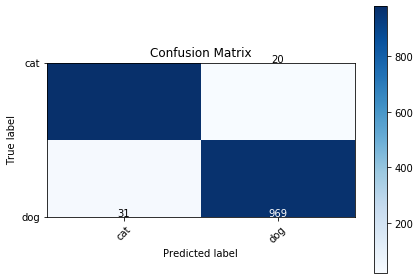

In [75]:
plot_confusion_matrix(cm=cm_16,classes=cm_plot_labels,title='Confusion Matrix')

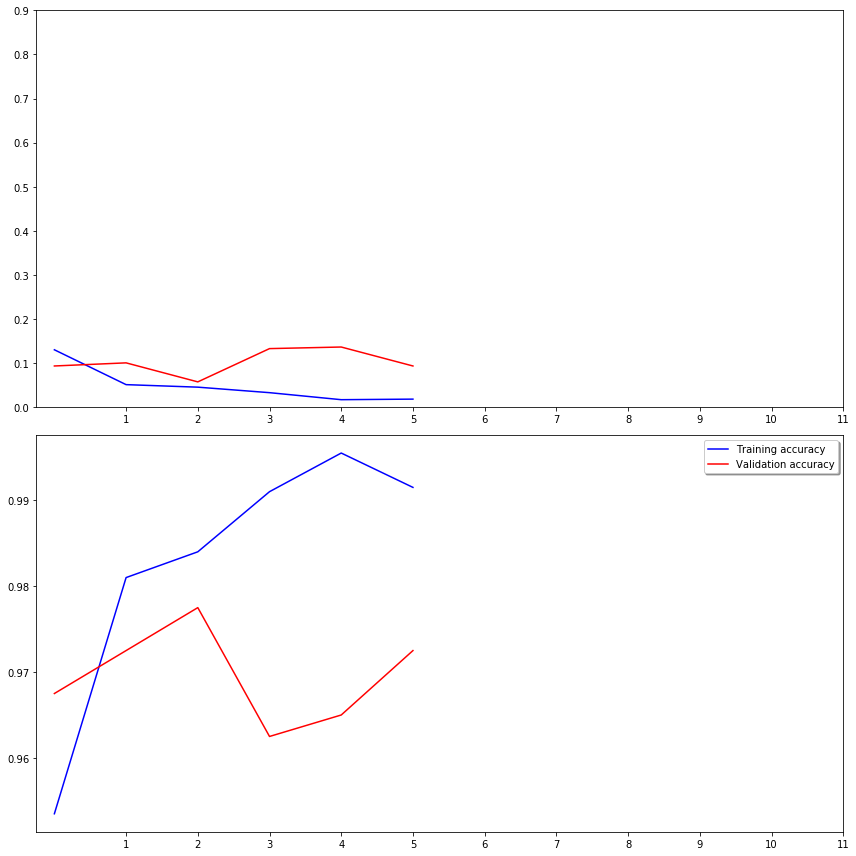

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(cnn_16.history.history['loss'], color='b', label="Training loss")
ax1.plot(cnn_16.history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 12, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(cnn_16.history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(cnn_16.history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 12, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [80]:
print(classification_report(y_true=test_generator.classes,y_pred=np.argmax(predictions_16,axis=-1)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       0.98      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [81]:
vgg16_fpr, vgg16_tpr, vgg16_threshold = roc_curve(test_generator.classes, np.argmax(predictions_16,axis=-1))

In [82]:
roc_auc_score(test_generator.classes, np.argmax(predictions_16,axis=-1))

0.9744999999999999

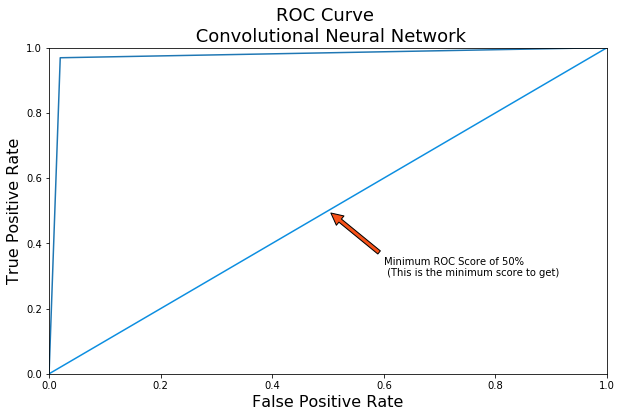

In [86]:
graph_roc_curve(vgg16_fpr, vgg16_tpr, vgg16_threshold)
plt.show()

In [87]:
if os.path.isfile('models/VGG16_model.h5') is False:
    cnn.save('models/VGG16_model.h5')
    